# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [1]:
# import libraries
import torch
import numpy as np

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
# help with split the training data
from torch.utils.data.sampler import SubsetRandomSampler


# number of subprocesses to use for data loading
# (if want to load data inparallel)
num_workers = 0
# how many samples per batch to load
# (number of training images that will be seen in one training iteration)
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2


# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
# list all the possible indices
indices = list(range(num_train))
# shuffle the indices 
np.random.shuffle(indices)
# defind a split boundary -- the number of examples we want to include in the validation set
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
# (add one more arguments to each of the loaders)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                          sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers)

The tensor datatype is a data type that's very similar to a NumPy array.
Only it can be moved onto a GPU for faster calculation. 

### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

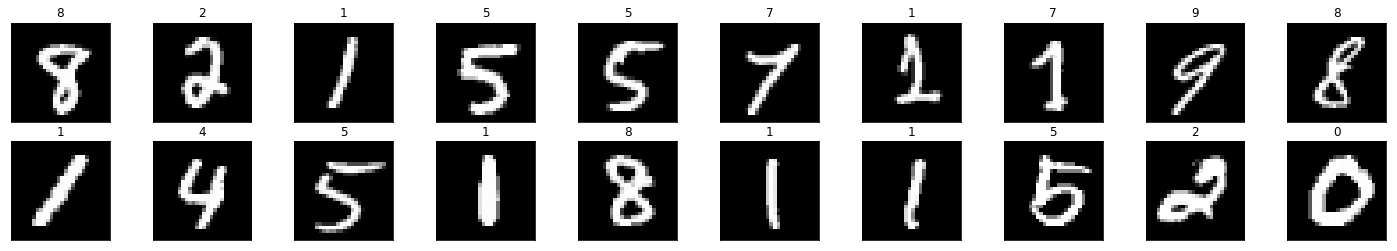

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

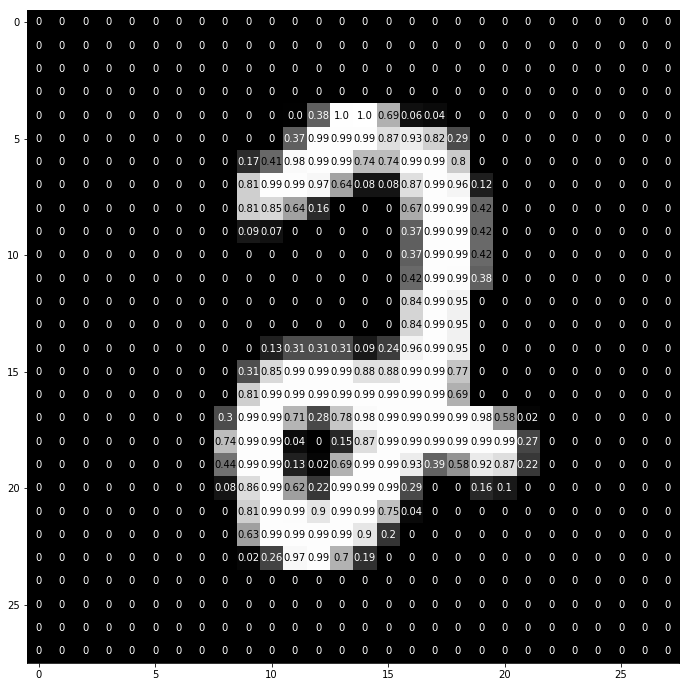

In [4]:
# Look at one image in our set
img = np.squeeze(images[1])

# Display the gray scale values of this image
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

## TODO: Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> 1 hidden node):
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # linear layer (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)
        
    # How will an input vector proceed through these layers:
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        # (not applying activation function to output layer)
        # (since later will have a softmax activation function applied to it)
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


#### Note:
The `__init__` function: to define any neural network in PyTorch you have to define and name any layers that have learned weight values in the `__init__` function. (So in this case, any fully-connected linear layers that you define.)
Next, you have to define the `feedforward` behavior of your network. This is just how an input X will be passed through various layers and transformed. Firstly, make sure to flatten the input image X by using the view function. `.view()` function takes in a number of rows and columns and then squishes and input into that desired shape. `x.view(-1, 28 * 28)`, with `-1` here, this function will automatically fit all of the x values into this column shape. The end result is that this `X` will be a vector of 784 values. Then, pass this flattened vector to our first fully-connected layer, then call this layer by name, pass in our input and apply an activation function (here is ReLU). Finally, return the transformed `X`.


#### ReLU Activation Function:
The purpose of an activation function is to scale the outputs of a layer so that they are a consistent, small value. Much like normalizing input values, this step ensures that our model trains efficiently!

A ReLU activation function stands for "Rectified Linear Unit" and is one of the most commonly used activation functions for hidden layers. It is an activation function, simply defined as the positive part of the input, `x`. So, for an input image with any negative pixel values, this would turn all those values to `0`, black. You may hear this referred to as "clipping" the values to zero; meaning that is the lower bound.

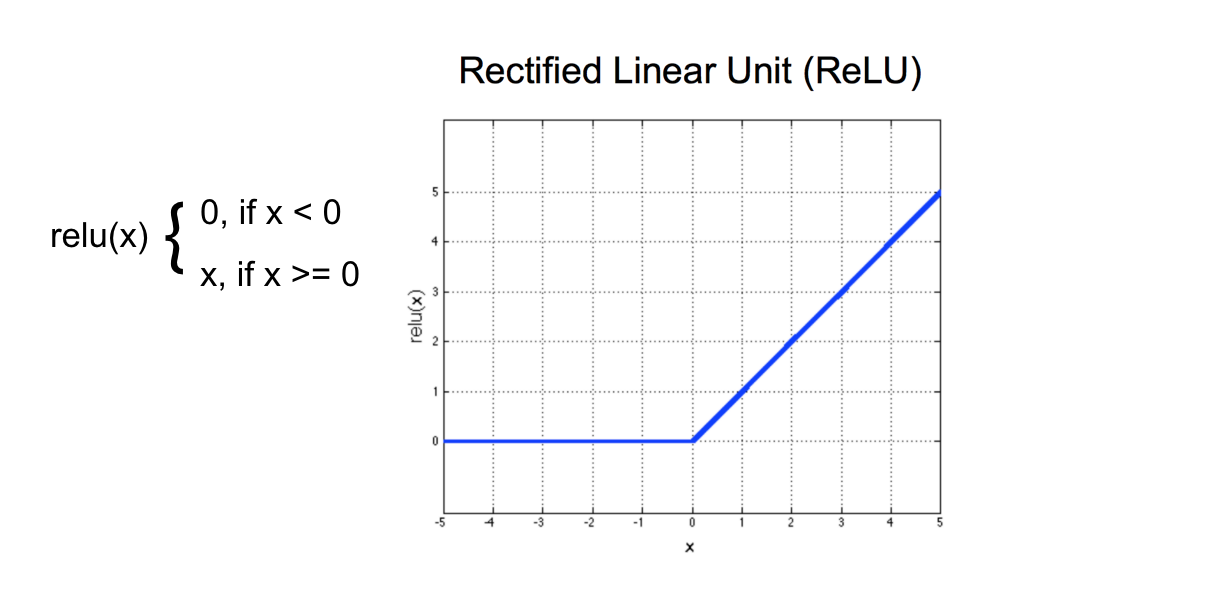



###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [6]:
## TODO: Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and Learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### Cross-Entropy Loss

In the PyTorch documentation, you can see that the cross entropy loss function actually involves two steps:
1. It first applies a softmax function to any output is sees
2. Then applies NLLLoss; negative log likelihood loss

Then it returns the average loss over a batch of data. Since it applies a softmax function, we do not have to specify that in the forward function of our model definition, but we could do this another way.

### Another approach 
We could separate the softmax and NLLLoss steps.
 - In the `forward` function of our model, we would explicitly apply a softmax activation function to the output, `x`.
 (a softmax layer to convert 10 outputs into a distribution of class probabilities.)
 `x = F.log_softmax(x, dim=1)`
 `return x` 
 
 - Then, when defining our loss criterion, we would apply NLLLoss
 (cross entropy loss combines softmax and nn.NLLLoss() in one single class. here, we've separated them)
 `criterion = nn.NLLLoss()`
 
This separates the usual `criterion = nn.CrossEntropy()` into two steps: softmax and NLLLoss, and is a useful approach should you want the output of a model to be class probabilities rather than class scores.

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

In [7]:
# number of epochs to train the model
n_epochs = 50  # suggest training between 20-50 epochs

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs): # <-- epoch loop
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader: # <-- batch loop
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        # (compare a batch of outputs and target labels and calculate the cross-entropy loss)
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update - update the weights)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    
    ###################
    # valid the model #
    ###################    
    for data, target in valid_loader: # <-- batch loop
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        # (compare a batch of outputs and target labels and calculate the cross-entropy loss)
        loss = criterion(output, target)
        # update running validation loss
        valid_loss += loss.item()*data.size(0)
        # (Notice: we are not performing the backpropagation step here)
        
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decrease ({:.6f} --> {:.6f}. Saving model ...'.format(
             valid_loss_min,
             valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min=valid_loss
        

Epoch: 1 	Training Loss: 0.746206 	Validation Loss: 0.085549
Validation loss decrease (inf --> 0.085549. Saving model ...
Epoch: 2 	Training Loss: 0.283168 	Validation Loss: 0.063241
Validation loss decrease (0.085549 --> 0.063241. Saving model ...
Epoch: 3 	Training Loss: 0.225516 	Validation Loss: 0.051479
Validation loss decrease (0.063241 --> 0.051479. Saving model ...
Epoch: 4 	Training Loss: 0.186353 	Validation Loss: 0.043209
Validation loss decrease (0.051479 --> 0.043209. Saving model ...
Epoch: 5 	Training Loss: 0.159752 	Validation Loss: 0.038415
Validation loss decrease (0.043209 --> 0.038415. Saving model ...
Epoch: 6 	Training Loss: 0.138115 	Validation Loss: 0.034395
Validation loss decrease (0.038415 --> 0.034395. Saving model ...
Epoch: 7 	Training Loss: 0.120890 	Validation Loss: 0.030925
Validation loss decrease (0.034395 --> 0.030925. Saving model ...
Epoch: 8 	Training Loss: 0.106794 	Validation Loss: 0.029587
Validation loss decrease (0.030925 --> 0.029587. Saving

Notice: the decrease slowing down after epoch 38. Our validation loss stays almost the same for the last 10 tp 15 epochs here. The lack of decrease indicates that the best model is really reached even around epoch 30 but definitely by epoch 38. 

Next, see how this model performs on our test data.

### Load the Mode with the Loweast Validation Loss

In [8]:
model.load_state_dict(torch.load('model.pt'))

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [9]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.059579

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1126/1135)
Test Accuracy of     2: 97% (1011/1032)
Test Accuracy of     3: 98% (991/1010)
Test Accuracy of     4: 98% (968/982)
Test Accuracy of     5: 97% (873/892)
Test Accuracy of     6: 98% (942/958)
Test Accuracy of     7: 97% (1007/1028)
Test Accuracy of     8: 97% (946/974)
Test Accuracy of     9: 96% (977/1009)

Test Accuracy (Overall): 98% (9811/10000)


#### `model.eval()`

There is an omission in the above code: including `model.eval()` ! 

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation. So, you should set your model to evaluation mode **before testing or validating your model** and set it to `model.train()` (training mode) only during the training loop.

#### Optional Resources
Check out the [first research paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) to propose dropout as a technique for overfitting.
If you would like more information on activation functions, check out this [website](http://cs231n.github.io/neural-networks-1/#actfun).

### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

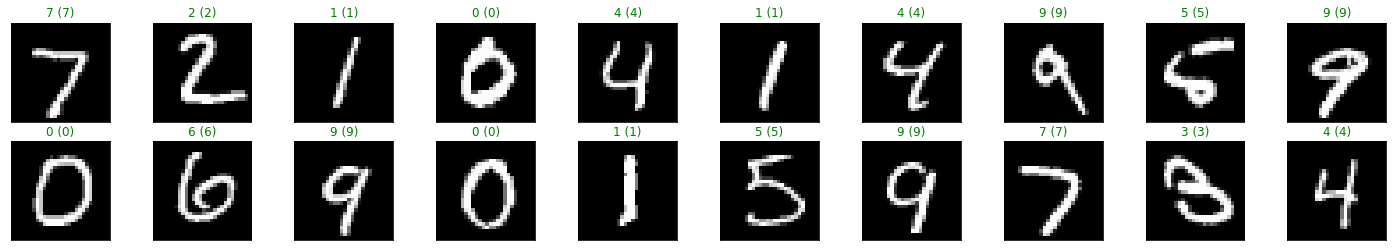

In [10]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

---
## Summary
### Validation Set: Takeaways

We create a validation set to:
1. Measure how well a model generalizes, during training
2. Tell us when to stop training a model; when the validation loss stops decreasing (and especially when the validation loss starts increasing and the training loss is still decreasing)